# Synthetic Data

In [87]:
import numpy as np
import torch
from torch import nn, Tensor
import torch.functional as F
from torch.distributions import Distribution
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader
#For PC-algorithm
import pandas as pd
import cdt
cdt.SETTINGS.rpath = "C:/PROGRA~1/R/R-42~1.2/bin/x64/Rscript"
# cdt.SETTINGS.rpath = "C:/Program Files/R/R-4.2.2/bin/x64/Rscript"
# cdt.SETTINGS.rpath = "C:/Users/bends/OneDrive/Skrivebord/R_PCalg.R"
# cdt.SETTINGS.rpath = '/usr/local/bin/Rscript' # this path should point to your own R implementation !
from cdt.causality.graph import PC
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
class SynthNN(nn.Module):
    def __init__(self, hidden_size = 6):
        super().__init__()
        self.function = nn.Sequential(
            nn.Linear(in_features=3, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=10),
        )
    def forward(self, Z):
        return self.function(Z)


def simulate_synthetic_data(samples, function):
    envs = np.array([0.2, 2, 3, 5])
    E = np.random.choice([0,1,2,3], size = samples)

    env = envs[E]
    Z1 = env + np.random.normal(0, 1, size = samples)
    Z2 = 2*env + np.random.normal(0, np.sqrt(2), size = samples)
    Y = Z1 + Z2 + np.random.normal(0, 1, size = samples)
    Z3 = Y + env + np.random.normal(0, 1, size = samples)
    Z = np.stack([Z1, Z2, Z3], axis = 1)

    if function == 'identity':
        X = Z
    elif function == 'linear':
        S = np.random.normal(size = (3,10))
        X = Z@S
    elif function == 'nonlinear':
        synthnn = SynthNN()
        X = synthnn(torch.tensor(Z).float()).detach().numpy()
    
    return X, Y, E, Z, env

In [3]:
torch.manual_seed(1) # Seed doesn't work for the PC-algorithm for some reason
model = SynthNN()
x, y, e, z, env = simulate_synthetic_data(4000, "nonlinear")
mean_x = np.mean(x,axis=1)

In [4]:
def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

e_onehot = one_hot(e,4)

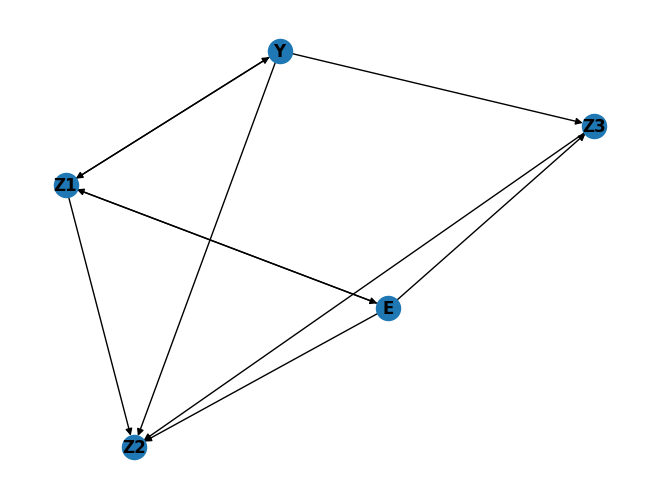

In [5]:
#All the data, can also just use mean_x
# data_ye = np.stack([e_onehot[:,0],e_onehot[:,1],e_onehot[:,2],e_onehot[:,3],y],axis=1)
# data = np.concatenate((x,z,data_ye), axis =1)
# permutation = np.arange(0,18)
# names = np.array(["X1","X2","X3","X4","X5","X6","X7","X8","X9","X10", "Z1", "Z2", "Z3","E1","E2","E3","E4","Y"])
#Only Y and Z
permutation = [0,1,2,3,4]
data = np.stack([z[:,0],z[:,1],z[:,2],e,y],axis = 1)
# data = np.concatenate((z,data_ye),axis=1)
names = np.array(["Z1","Z2","Z3","E","Y"])
data_df = pd.DataFrame(data, columns = names)
pc_test = PC(CItest = 'gaussian', alpha = 0.05, verbose=False).create_graph_from_data(data_df[names[permutation]])

nx.draw(pc_test, with_labels=True, font_weight='bold')
plt.show()

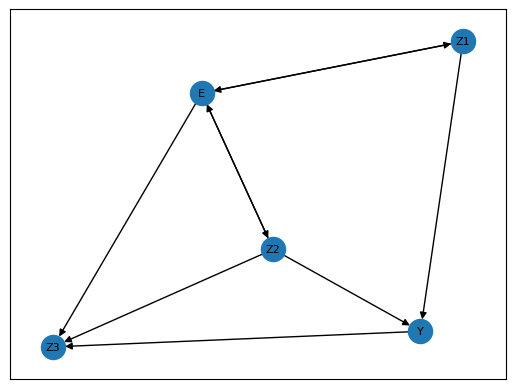

In [6]:
#This seems to work better for some reason??
permutation = [0,1,2,3,4]
data = np.stack([z[:,0],z[:,1],z[:,2],e,y],axis = 1)
names = np.array(["Z1","Z2","Z3","E","Y"])
data_df = pd.DataFrame(data, columns = names)
pc = PC()
output = pc.predict(data_df)
# pc_test = PC(CItest = 'gaussian', alpha = 0.05, verbose=False).create_graph_from_data(data_df[names[permutation]])

# nx.draw(pc_test, with_labels=True, font_weight='bold')
# plt.show()

nx.draw_networkx(output,font_size = 8)
plt.show()

In [7]:
class EnvDataset(Dataset):
    def __init__(self, X, Y, E):
        super().__init__()
        self.X = torch.tensor(X)
        self.Y = torch.tensor(Y).unsqueeze(1)
        E = torch.tensor(E) #From Peter
        # self.E = torch.nn.functional.one_hot(torch.tensor(E))
        self.E = torch.nn.functional.one_hot(E.long())
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index], self.E[index] 
    
    def __len__(self):
        return(len(self.X))

In [28]:
dset.X.chunk(2,dim=-1)[0]

<function Tensor.mean>

## Generate data

In [37]:
torch.manual_seed(1)
X, Y, envs, Z, E = simulate_synthetic_data(8000, 'nonlinear')
dset = EnvDataset(X[:4000],Y[:4000],envs[:4000])
train_loader = DataLoader(dset, batch_size=128, drop_last=True)
dset = EnvDataset(X[4000:],Y[4000:],envs[4000:])
test_loader = DataLoader(dset, batch_size=128, drop_last=True)

#Much smaller sample:
# X, Y, envs, Z, E = simulate_synthetic_data(1000, 'nonlinear')
# dset = EnvDataset(X[:500],Y[:500],envs[:500])
# train_loader = DataLoader(dset, batch_size=128, drop_last=True)
# dset = EnvDataset(X[500:],Y[500:],envs[500:])
# test_loader = DataLoader(dset, batch_size=128, drop_last=True)

## iCARL from Thea

In [148]:
class Encoder(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super().__init__()
        self.linear = nn.Linear(in_features=input_size, out_features=6)
        self.relu = nn.ReLU()
        self.output = nn.Linear(in_features=6, out_features=2*output_size)
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        z = self.output(x)
        return z.chunk(2, dim = -1)

class Decoder(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super().__init__()
        self.linear = nn.Linear(in_features=input_size, out_features=6)
        self.relu = nn.ReLU()
        self.output = nn.Linear(in_features=6, out_features=output_size)
        
    def forward(self, z):
        z = self.linear(z)
        z = self.relu(z)
        mean = self.output(z)
        return mean

class NLPrior(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super().__init__()
        self.function = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=output_size*2)
        )
    def forward(self, x):
        return self.function(x).chunk(2, axis = -1)

class NLClassifier(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super().__init__()
        self.function = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=output_size),
            # nn.Softmax(dim = -1)
        )
    def forward(self, x):
        return self.function(x)


class Normal_dist(Distribution):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.c = 2 * np.pi * torch.ones(1).to(self.device)
        self._dist = dist.normal.Normal(torch.zeros(1).to(self.device), torch.ones(1).to(self.device))
        self.name = 'gauss'

    def sample(self, mu, v):
        with torch.no_grad():
            eps = self._dist.sample(mu.size()).squeeze()
        scaled = eps.mul(v.sqrt())
        return scaled.add(mu)

    def log_pdf(self, x, mu, v, reduce=True, param_shape=None):
        """compute the log-pdf of a normal distribution with diagonal covariance"""
        if param_shape is not None:
            mu, v = mu.view(param_shape), v.view(param_shape)
        lpdf = -0.5 * (torch.log(self.c) + v.log() + (x - mu).pow(2).div(v))
        if reduce:
            return lpdf.sum(dim=-1)
        else:
            return lpdf

In [149]:
class generalNFprior(nn.Module):
    def __init__(self, hidden_dim, ye_dim, output_size, TNN, lambdaNN, lambdaf):
        super().__init__()
        self.TNN = TNN(hidden_dim, output_size)
        self.lambdaNN = lambdaNN(ye_dim, output_size)
        self.lambdaf = lambdaf(ye_dim, hidden_dim * 2)

    def forward(self, z, ye):
        TNN_params, _ = self.TNN(z)
        lambdaNN_params, _ = self.lambdaNN(ye)
        lambdaf_params, _ = self.lambdaf(ye)

        return TNN_params, lambdaNN_params, lambdaf_params
    
    def log_pdf(self, z, TNN_params, lambdaNN_params, lambdaf_params, reduce = True):
        nn_ = (TNN_params*lambdaNN_params).sum(dim = 1)
        z_cat = torch.cat((z, z.pow(2)), dim = 1)
        f_ = (z_cat * lambdaf_params).sum(dim = 1)

        return nn_ + f_

In [150]:
class iCARL_NF_iVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, y_dim, e_dim, encoder, decoder, priorNN, prior_output = 1, device = 'cpu') -> None:
        super().__init__()
        self.encoder = encoder(input_dim + y_dim + e_dim, hidden_dim).to(device)
        self.decoder = decoder(hidden_dim, input_dim).to(device)
        self.prior = generalNFprior(hidden_dim, y_dim+e_dim, prior_output, priorNN, priorNN, priorNN)

        self.decoder_var = 0.01*torch.ones(1).to(device)
        self.encoder_dist = Normal_dist(device = device)
        self.decoder_dist = Normal_dist(device = device)
    
    def encoder_params(self, x, y, e):
        xye = torch.cat((x, y, e), 1)
        g, logv = self.encoder(xye)
        return g, logv.exp()
    
    def decoder_params(self, z):
        f = self.decoder(z)
        return f, self.decoder_var
    
    def prior_params(self, z, y, e):
        ye = torch.cat((y,e), 1)
        TNN_params, lambdaNN_params, lambdaf_params = self.prior(z, ye)

        return TNN_params, lambdaNN_params, lambdaf_params

    def forward(self, x, y, e):
        encoder_params = self.encoder_params(x, y, e)

        z = self.encoder_dist.sample(*encoder_params)
        
        decoder_params = self.decoder_params(z)

        return decoder_params, encoder_params, z
    
    def elbo(self, x, y, e):

        decoder_params, encoder_params, z = self.forward(x, y, e)
        log_px_z = self.decoder_dist.log_pdf(x, *decoder_params)
        log_qz_xye = self.encoder_dist.log_pdf(z, *encoder_params)
        
        z_temp = z.detach().requires_grad_(requires_grad = True)
        prior_params = self.prior_params(z_temp, y.detach(), e.detach())
        pz_ye = self.prior.log_pdf(z_temp, *prior_params)

        dpz_ye = torch.autograd.grad(pz_ye.mean(), z_temp, create_graph = True, retain_graph=True)[0]
            
        ddpz_ye = torch.autograd.grad(dpz_ye.sum(), z_temp, create_graph = True, retain_graph=True)[0]
            
        SM = (ddpz_ye + 0.5 * dpz_ye.pow(2)).sum(1)
        
        elbo = log_px_z - log_qz_xye + pz_ye.detach()
        
        return elbo.mean()-SM.mean(), elbo.mean(), SM.mean()

In [151]:
iCARL = iCARL_NF_iVAE(10, 3, 1, 4, Encoder, Decoder, NLPrior, prior_output = 1, device = 'cpu')

<class '__main__.Normal_dist'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.


In [152]:
x,y,e = next(iter(train_loader))
elbo = iCARL.elbo(x.float(),y.float(),e.float())

In [153]:
elbo

(tensor(-480.7868, grad_fn=<SubBackward0>),
 tensor(-480.7435, grad_fn=<MeanBackward0>),
 tensor(0.0434, grad_fn=<MeanBackward0>))

In [154]:
from torch.optim import Adam
optimizer = Adam(iCARL.parameters(), lr=1e-3)

In [155]:
epochs = 200
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

iCARL.train()
for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss, elbo, SM = iCARL.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)

Epoch 20 of 200
Train loss: tensor(-231.7129)
Epoch 40 of 200
Train loss: tensor(-2267.2900)
Epoch 60 of 200
Train loss: tensor(-7010.2671)
Epoch 80 of 200
Train loss: tensor(-12120.7432)
Epoch 100 of 200
Train loss: tensor(-17307.8809)
Epoch 120 of 200
Train loss: tensor(-20285.3535)
Epoch 140 of 200
Train loss: tensor(-15158.4541)
Epoch 160 of 200
Train loss: tensor(-3939.0132)
Epoch 180 of 200
Train loss: tensor(-3609.9143)
Epoch 200 of 200
Train loss: tensor(-4515.9917)


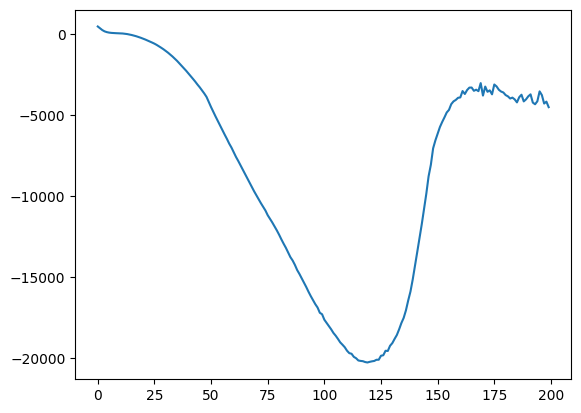

In [156]:
plt.plot(train_loss)
plt.show()

In [161]:
# get z
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 3))
envs_samp = np.zeros((len(train_loader)*128, 4))
y_samp = np.zeros((len(train_loader)*128,1))
i = 0
with torch.no_grad():
    for x,y,e in train_loader:
        _,_,z = iCARL.forward(x.float(), y.float(), e.float())
        latent_variables[i*128:i*128+128,:] = z.detach()
        envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
        y_samp[i*128:i*128+128] = y.numpy()
        i+=1



In [165]:
classifier = NLClassifier(3,1)
loss_MSE = nn.MSELoss()

In [166]:
output = classifier(z[1:3,:]).view(-1)
loss_MSE(output,y[1:3,0])

tensor(1610.3475, dtype=torch.float64, grad_fn=<MseLossBackward0>)

>> Using device: cpu
Epoch  1 : , Train acc 951.664917, Valid acc 955.442200
Epoch  2 : , Train acc 534.776245, Valid acc 536.764099
Epoch  3 : , Train acc 360.259766, Valid acc 362.081055
Epoch  4 : , Train acc 265.756561, Valid acc 267.735687
Epoch  5 : , Train acc 208.166321, Valid acc 209.564178
Epoch  6 : , Train acc 170.438095, Valid acc 171.665802
Epoch  7 : , Train acc 143.677139, Valid acc 145.004761
Epoch  8 : , Train acc 123.958931, Valid acc 125.174545
Epoch  9 : , Train acc 108.979958, Valid acc 110.259804
Epoch 10 : , Train acc 97.507286, Valid acc 98.725883
Epoch 11 : , Train acc 88.473434, Valid acc 89.783630
Epoch 12 : , Train acc 81.361168, Valid acc 82.592735
Epoch 13 : , Train acc 75.647522, Valid acc 76.933464
Epoch 14 : , Train acc 70.964340, Valid acc 72.332069
Epoch 15 : , Train acc 67.144943, Valid acc 68.433784
Epoch 16 : , Train acc 64.060303, Valid acc 65.247719
Epoch 17 : , Train acc 61.474712, Valid acc 62.723026
Epoch 18 : , Train acc 59.291004, Valid acc

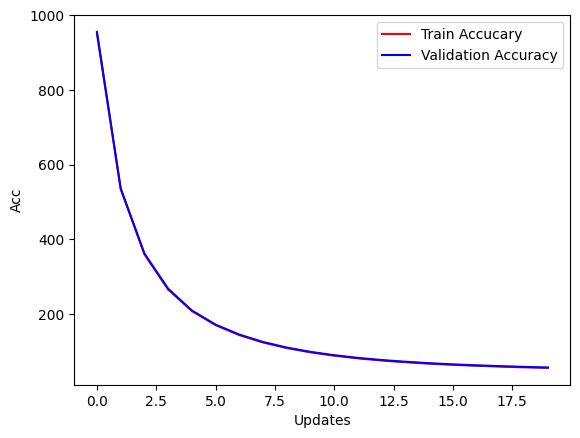

In [167]:
#Synthetic data classifier
epoch = 0
num_epochs = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# training..
training_epoch_data = []
test_epoch_data = []
test_acc, train_acc = [], []

while epoch < num_epochs:
    epoch+= 1
    training_batch_data = []
    test_batch_data = []
    classifier.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x,y,e in train_loader:
        _,_,z = iCARL.forward(x.float(), y.float(), e.float())

        #Get classification prediction
        output = classifier(z).view(-1)

        loss = loss_MSE(output, y.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        # gather data for the current batch
        training_batch_data.append(loss)
            

    # gather data for the full epoch
    training_epoch_data.append(torch.tensor(training_batch_data).mean())


    #Evaluate training
    with torch.no_grad():
        classifier.eval()
        train_targs, train_preds = [], []
        for x,y,e in train_loader:
            _,_,z = iCARL.forward(x.float(), y.float(), e.float())

            #Get classification prediction
            output = classifier(z).view(-1)
            train_targs += list(y.view(-1).numpy())
            train_preds += list(output.data.numpy())

        #Evaluating validation
        val_targs, val_preds = [], []
        for x,y,e in test_loader:
            _,_,z = iCARL.forward(x.float(), y.float(), e.float())

            #Get classification prediction
            output = classifier(z).view(-1)

            val_targs += list(y.view(-1).numpy())
            val_preds += list(output.data.numpy())

    train_acc_cur = loss_MSE(Tensor(train_targs),Tensor(train_preds))
    train_acc.append(train_acc_cur)

    test_acc_cur = loss_MSE(Tensor(val_targs),Tensor(val_preds))
    test_acc.append(test_acc_cur)
    print("Epoch %2i : , Train acc %f, Valid acc %f" % (
                epoch, train_acc_cur, test_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, test_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')
plt.show()


In [275]:
env_samp = np.zeros((len(train_loader)*128,1))
for i in range(0,4):
    env_samp[envs_samp[:,i]==1] = i+1


Trying PC-algorithm on the latent variables generated by iCARL

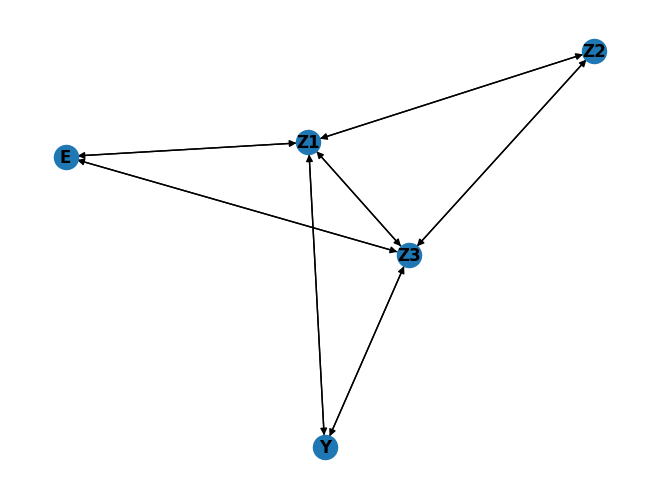

In [281]:
permutation = [0,1,2,3,4]
# data = np.stack([latent_variables[:,0],latent_variables[:,1],latent_variables[:,2],env_samp,y_samp],axis = 1)
data = np.concatenate((latent_variables,env_samp,y_samp),axis=1)
names = np.array(["Z1","Z2","Z3","E","Y"])
data_df = pd.DataFrame(data, columns = names)
pc_test = PC(CItest = 'gaussian', alpha = 0.05, verbose=False).create_graph_from_data(data_df[names[permutation]])

nx.draw(pc_test, with_labels=True, font_weight='bold')
plt.show() #Obviously not satisfying :(